In [1]:
import numpy as np 
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# Initial Data Analysis

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 

df = pd.DataFrame(wine_quality.data.original)

#replacing red and white in the target variable 0 and 1
df['color'] = df['color'].map({'red':0, 'white':1})

print(df)

correlation_matrix = df.corr()

# Correlation with 'color' column
correlation_with_color = correlation_matrix['color']

print(correlation_with_color)

avg_quality = df.groupby("color").mean()
avg_quality

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
color,,,,,,,,,,,,
0,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
1,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909


In [3]:
difference = avg_quality.diff().iloc[1]

# take the absolute value of the differences
absolute_difference = difference.abs()

# sort the absolute differences in descending order
sorted_absolute_difference = absolute_difference.sort_values(ascending=False)

# normalize the absolute differences
scaler = MinMaxScaler()
scaled_absolute_difference = pd.DataFrame(scaler.fit_transform(absolute_difference.values.reshape(-1, 1)),
                                           index=absolute_difference.index, columns=['Scaled Difference'])

# sort the scaled absolute differences in descending order
sorted_scaled_absolute_difference = scaled_absolute_difference.sort_values(by='Scaled Difference', ascending=False)

print("Scaled difference between the features of red and white wine:")
sorted_scaled_absolute_difference

Scaled difference between the features of red and white wine:


,Scaled Difference
total_sulfur_dioxide,1.000000
free_sulfur_dioxide,0.211453
residual_sugar,0.041897
fixed_acidity,0.015912
volatile_acidity,0.002686
quality,0.002603
sulphates,0.001802
pH,0.001307
alcohol,0.000964
citric_acid,0.000658


From this, it appears total sulfur dioxide, free sulfur dioxide, and residual sugars vary the most among red or white wine.

# Model Formulation

In [4]:
class Perceptron:
    def __init__(self):
        # Initialize variables
        self.features = None  # Features of the dataset
        self.labels = None    # Labels of the dataset
        self.weights = None   # Weights for the features
        self.bias = None      # Boolean indicating whether bias is used
        self.learning_rate = None  # Learning rate
        self.max_iterations = None  # Maximum number of iterations
        self.weights_history = []   # History of weights during training
        self.loss_history = [np.inf]   # History of loss during training

    # Activation function
    def sign(self, x, y):
        """
        Activation function (Step function)

        Args:
            x (numpy.ndarray): Feature vector
            y (numpy.ndarray): Weight vector

        Returns:
            int: 1 if x @ y > 0, else -1
        """
        if x @ y > 0:
            return 1
        else:
            return -1

    # Calculate loss
    def loss(self):
        """
        Calculate the loss using current weights and labels

        Returns:
            float: Loss value
        """
        return sum(0.5 * (self.sign(self.weights, x) - self.labels[i]) ** 2 for i, x in enumerate(self.features))

    # Approximate gradient
    def grad_approx(self, x, y):
        """
        Approximate gradient for a given feature vector and label

        Args:
            x (numpy.ndarray): Feature vector
            y (int): Label

        Returns:
            numpy.ndarray: Gradient approximation
        """
        return (self.sign(self.weights, x) - y) * x

    # Update weights
    def update_weights(self, idx):
        """
        Update the weights using the gradient descent update rule

        Args:
            idx (int): Index of the data point to update the weights
        """
        self.weights = self.weights - self.learning_rate * self.grad_approx(self.features[idx], self.labels[idx])
        self.weights_history.append(self.weights)

    # Fit the model
    def fit(self, features, labels, bias=True, learning_rate=0.01, max_iterations=100):
        """
        Fit the perceptron model to the given data

        Args:
            features (pandas.DataFrame): Features of the dataset
            labels (pandas.Series): Labels of the dataset
            bias (bool, optional): Whether to include bias. Defaults to True.
            learning_rate (float, optional): Learning rate. Defaults to 0.01.
            max_iterations (int, optional): Maximum number of iterations. Defaults to 100.
        """
        self.features = features.to_numpy()
        self.labels = labels.to_numpy()
        if bias:
            ones_column = np.ones((self.features.shape[0], 1))
            self.features = np.append(ones_column, self.features, axis=1)
        self.weights = np.random.rand(self.features.shape[1])
        self.bias = bias
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations

        # Training loop
        for i in range(1, max_iterations + 1):
            random_idx = np.random.randint(self.features.shape[0])
            self.update_weights(random_idx)
            loss = self.loss()
            self.loss_history.append(loss)
            if i >= self.max_iterations:
                break

    # Predict labels for new data
    def predict(self, new_features):
        """
        Predict labels for new data using the trained model

        Args:
            new_features (pandas.DataFrame): New data features

        Returns:
            list: Predicted labels
        """
        new_features = new_features.to_numpy()
        if self.bias:
            ones_column = np.ones((new_features.shape[0], 1))
            new_features = np.append(ones_column, new_features, axis=1)
        predictions = [self.sign(x, self.weights) for x in new_features]
        return predictions

# Model Implementation

In [5]:
#define a function which takes the dataset as input and ouputs the processed dataset
def preprocessor(df):
    """
    Preprocesses the dataset by encoding categorical features using LabelEncoder

    Args:
        df (pandas.DataFrame): Input dataset

    Returns:
        pandas.DataFrame: Processed dataset with encoded categorical features
    """
    # make a copy of the original dataframe to avoid modifying the original data
    res_df = df.copy()
    
    # initialize LabelEncoder
    le = preprocessing.LabelEncoder()
    
    # Encode categorical features using LabelEncoder
    res_df['sulphates'] = le.fit_transform(res_df['sulphates'])
    res_df['total_sulfur_dioxide'] = le.fit_transform(res_df['total_sulfur_dioxide'])
    res_df['residual_sugar'] = le.fit_transform(res_df['residual_sugar'])
    res_df['pH'] = le.fit_transform(res_df['pH'])
    res_df['chlorides'] = le.fit_transform(res_df['chlorides'])
    res_df['density'] = le.fit_transform(res_df['density'])
    res_df['citric_acid'] = le.fit_transform(res_df['citric_acid'])
    res_df['fixed_acidity'] = le.fit_transform(res_df['fixed_acidity'])
    
    # Return the processed dataframe
    return res_df

# Run the preprocessor function on the desired dataset
encoded_df = preprocessor(df)

In [6]:
#selecting features
X = encoded_df.drop(columns=['color', 'fixed_acidity', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'pH', 'sulphates', 'alcohol', 'quality'],axis =1)
y = encoded_df['color']
# make sure right columns were dropped
print(X)

      residual_sugar  free_sulfur_dioxide  total_sulfur_dioxide
0                 23                 11.0                    28
1                 36                 25.0                    61
2                 31                 15.0                    48
3                 23                 17.0                    54
4                 23                 11.0                    28
...              ...                  ...                   ...
6492              17                 24.0                    87
6493             126                 57.0                   167
6494               9                 30.0                   106
6495               7                 20.0                   105
6496               2                 22.0                    93

[6497 rows x 3 columns]


In [7]:
#standardizing features
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

Text(0, 0.5, 'Total Sulfur Dioxide')

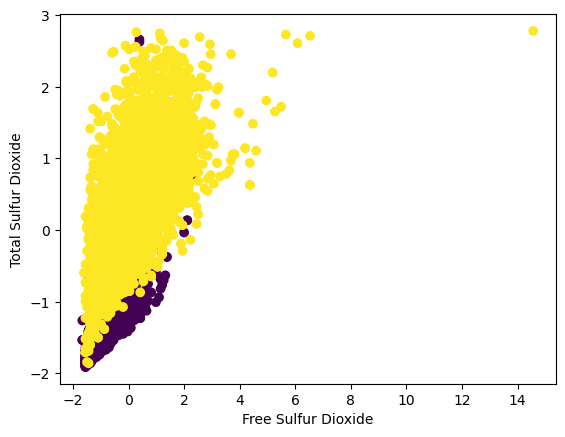

In [8]:
#visualization
plt.scatter(X.iloc[:, 1], X.iloc[:,2], c=y)
plt.xlabel('Free Sulfur Dioxide')
plt.ylabel('Total Sulfur Dioxide')

Text(0, 0.5, 'Total Sulfur Dioxide')

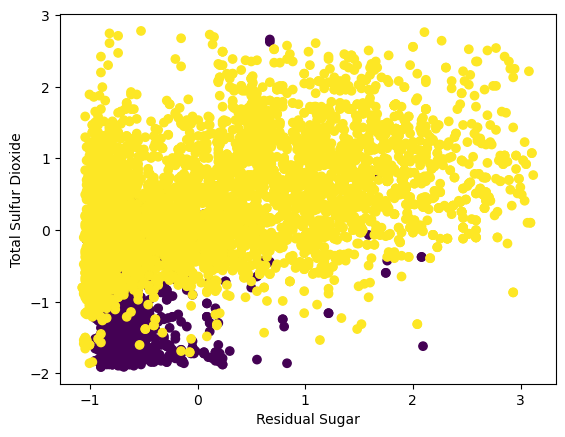

In [9]:
#visualization
plt.scatter(X.iloc[:, 0], X.iloc[:,2], c=y)
plt.xlabel('Residual Sugar')
plt.ylabel('Total Sulfur Dioxide')

Data does not appear to be linearly seperable as much of the red wine is "behind" the white. I predict this model might not be the best for this type of classification.

In [10]:
# split the dataset into training and testing sets
test_size = 0.20  # percentage of data to be used for testing
random_state = 30  # seed for random number generator, ensures reproducibility

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [11]:
#instantiate the model
model = Perceptron()
#fit the model with data
model.fit(X_train, y_train, learning_rate=0.001, max_iterations=5000)

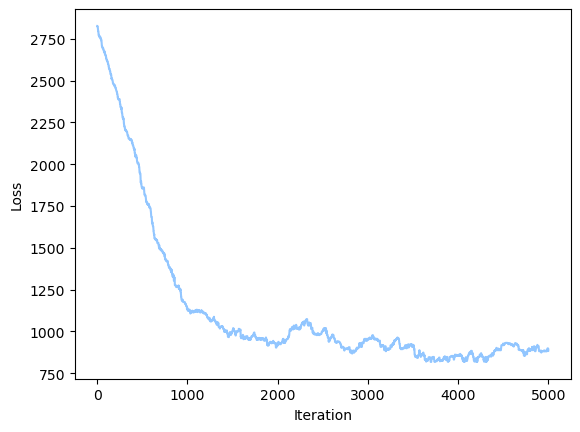

In [12]:
#loss history during training
plt.plot(model.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

An erratic loss history plot in the training of a perceptron model, such as this one after 2000 iterations, indicates instability during training, potentially stemming from challenges in convergence, noisy data, or the model's capacity to handle the dataset's complexity. This behavior suggests the need for adjustments in hyperparameters, such as the learning rate and maximum iterations, as well as potential preprocessing techniques or alternative algorithms to enhance model stability and performance.

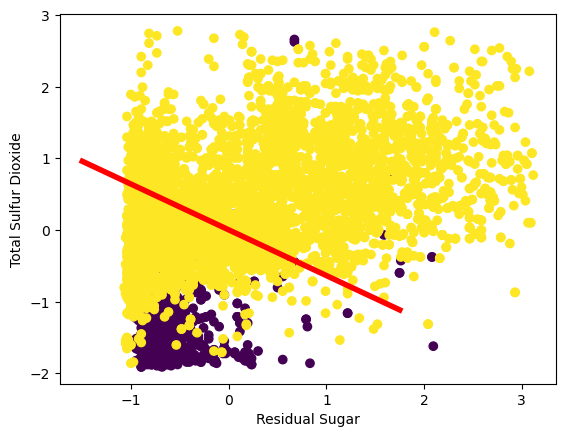

In [13]:
plt.scatter(X.iloc[:, 0], X.iloc[:,2], c=y, cmap='viridis')

domain = np.arange(-1.5, 2, 0.25)
w = model.weights
line = [-(w[1:2]*x)/w[0] for x in domain]

plt.plot(domain, line, color = 'red', linewidth = 4)
plt.xlabel('Residual Sugar')
plt.ylabel('Total Sulfur Dioxide')
plt.show()

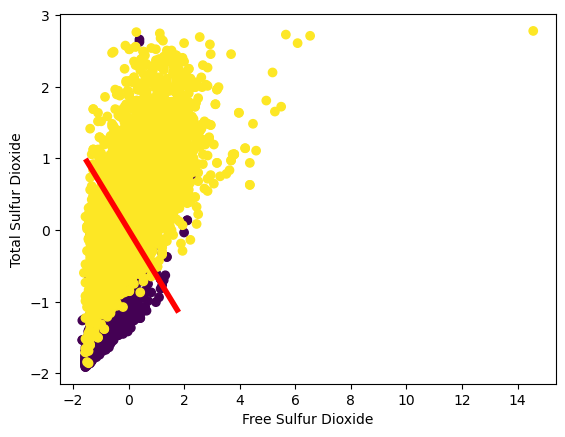

In [14]:
plt.scatter(X.iloc[:, 1], X.iloc[:,2], c=y, cmap='viridis')

domain = np.arange(-1.5, 2, 0.25)
w = model.weights
line = [-(w[1:2]*x)/w[0] for x in domain]

plt.plot(domain, line, color = 'red', linewidth = 4)
plt.xlabel('Free Sulfur Dioxide')
plt.ylabel('Total Sulfur Dioxide')
plt.show()

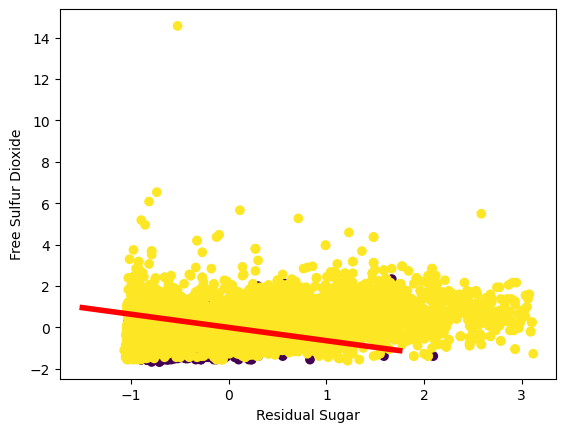

In [15]:
plt.scatter(X.iloc[:, 0], X.iloc[:,1], c=y, cmap='viridis')

domain = np.arange(-1.5, 2, 0.25)
w = model.weights
line = [-(w[1:2]*x)/w[0] for x in domain]

plt.plot(domain, line, color = 'red', linewidth = 4)
plt.xlabel('Residual Sugar')
plt.ylabel('Free Sulfur Dioxide')
plt.show()

In [18]:
y_pred = model.predict(X_train)
print(f'Training accuracy score = {accuracy_score(y_train, y_pred)}')

y_pred_test = model.predict(X_test)
print(f'Test accuracy score = {accuracy_score(y_test, y_pred_test)}')

Training accuracy score = 0.728689628631903
Test accuracy score = 0.7453846153846154


The training accuracy score of 0.729 and the test accuracy score of 0.745 suggest that the perceptron model performs similarly on both the training and test datasets. The close proximity of these scores indicates that the model is not overfitting significantly to the training data, demonstrating a reasonable level of generalization to unseen data.